In [1]:
!pip install torch
# Torch를 기반으로 하며, 자연어 처리와 같은 애플리케이션을 위해 사용된다. 
# GPU사용이 가능하기 때문에 속도가 상당히 빠르다

In [2]:
!pip install torchvision
# 파이토치가 제공하는 다양한 모델을 가져다 쓰기 위해 사용되는 라이브러리

In [3]:
!pip install ipywidgets
# 이미지를 커서를 가지고 이동하면서 이미지를 볼 수 있게하는 라이브러리(슬라이딩 등)

In [4]:
import torch
import copy
import os
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from ipywidgets import interact
from torch import nn

# 1. 이미지 파일 경로 불러오기

In [5]:
def list_image_file(data_dir, sub_dir): # './Covid19-dataset/train/', 'Normal'
    image_format = ['jpeg', 'jpg', 'png']
    image_files = []
    
    image_dir = os.path.join(data_dir, sub_dir) # './Covid19-dataset/train/Normal'
#     print(images_dir)
# 이미지 디렉토리를 만들어서 os.listdir : 경로에 있는 파일을 리스트화하여 file_path에 넣어 줘라
    for file_path in os.listdir(image_dir):
         # 점을 기준으로 (파일이름이랑 확장명 기준으로) [-1] : 끝에거(확장명) 
        # image_format(확장명) -> 이 있다면 
        if file_path.split('.')[-1] in image_format:
             # 파일 이름 경로들을 합처서 넣어라 -> Normal\\001.jpeg
            image_files.append(os.path.join(sub_dir, file_path))
    return image_files

In [6]:
data_dir = './Covid19-dataset/train/'
normals_list = list_image_file(data_dir, 'Normal')
covids_list = list_image_file(data_dir, 'Covid') # Covid : 폴더이름
pneumonias_list = list_image_file(data_dir, 'Viral Pneumonia')

In [7]:
print(len(normals_list))
print(len(covids_list))
print(len(pneumonias_list))

70
111
70


# 2. 이미지 파일을 RGB3차원 배열로 불러오기

In [8]:
def get_RGB_image(data_dir, file_name):
    # 경로화 시키기 path.join() : 스트링 값으로 사용하지 않는 이유는 특정 함수에서 경로로 인식되지 
    # 않기 때문에 join 방식을 합치는것이 이유이다.
    image_file = os.path.join(data_dir, file_name)
     # 읽어들어와 저장
    image = cv2.imread(image_file)
    # 엠디어레이로 저장되어 있기 때문에 그리고 cv2로 읽어오면 bgr로 읽어와서 바꿔주자    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [9]:
# 3가지 사진의 수 가 다르기 때문에 3개의 길이를 구하고 최솟값을 구해 그 최솟값을 기준으로 만든다.
min_num_files = min(len(normals_list), len(covids_list), len(pneumonias_list))
# interact 슬라이딩 만들기 위해 0부터 70 -1 까지 범위를 지정한다
@interact(index=(0, min_num_files-1))
def show_samples(index=0):
      # 현제 데이터 디렉토리에 정상인 사진들을 위 함수에 넣어 알지비로 넣어라
    normal_image = get_RGB_image(data_dir, normals_list[index])
    covid_image = get_RGB_image(data_dir, covids_list[index])
    pneumonia_image = get_RGB_image(data_dir, pneumonias_list[index])
    
    plt.figure(figsize=(12, 8))
    # matplotlib 여러 개의 그래프를 하나의 그림에 나타내도록 
    # 3개의 그래프중 한개를 그리고 첫번째이다.    
    plt.subplot(131)
    plt.title('Normal')
    plt.imshow(normal_image)
    
    plt.subplot(132)
    plt.title('Covid')
    plt.imshow(covid_image)
    
    plt.subplot(133)
    plt.title('Pneumonia')
    plt.imshow(pneumonia_image)
    plt.tight_layout()

interactive(children=(IntSlider(value=0, description='index', max=69), Output()), _dom_classes=('widget-intera…

# 3. 학습 데이터셋 클래스 만들기

- 데이터 셋: 데이터(샘플, 정답)을 저장한 것
- 데이터 로더: 데이터셋을 접근하기 쉽게 객체(tierable)로 감싼 것

In [10]:
train_data_dir = './Covid19-dataset/train/'
class_list = ['Normal', 'Covid', 'Viral Pneumonia']

# 데이터셋 : 데이터(샘플, 검증)을 저장한 것
# 데이터로더: 데이터셋을 접근하기 쉽도록 객체(iterable)로 감싼 것

class Chest_dataset(Dataset):
    def __init__(self, data_dir, transform=None): #transform=> train, Test인지 구분하기 위해서
        self.data_dir = data_dir
        normals = list_image_file(data_dir, 'Normal') # 데이터 뽑아오기
        covids = list_image_file(data_dir, 'Covid')
        pneumonias = list_image_file(data_dir, 'Viral Pneumonia')
        self.files_path = normals + covids + pneumonias # 리스트를 다 더해라 : 갯수가 전부 합쳐지게 된다.
        self.transform = transform
        
       # __len__ : len() 구현하기 위한   
    def __len__(self):
        return len(self.files_path)
     # __getitem__ : 인덱스의 순서를 찾아주는 것, 인덱싱하게 되면 호출되는 메소드
    def __getitem__(self, index):
        image_file = os.path.join(self.data_dir, self.files_path[index])
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # os.sep: 디렉토리 분리 문자를 리턴 (/), Normal/01.jpeg
#         print(self.files_path[index].split(os.sep))
#         print(self.files_path[index].split(os.sep)[-2])
        target = class_list.index(self.files_path[index].split(os.sep)[-2])
    #         target = class_list.index(self.files_path[index].split(os.sep)[0])
        if self.transform:
            image = self.transform(image)
            target = torch.Tensor([target]).long()# 숫자로 변환 long형으로
        return {'image':image, 'target':target}

In [11]:
dset = Chest_dataset(train_data_dir)

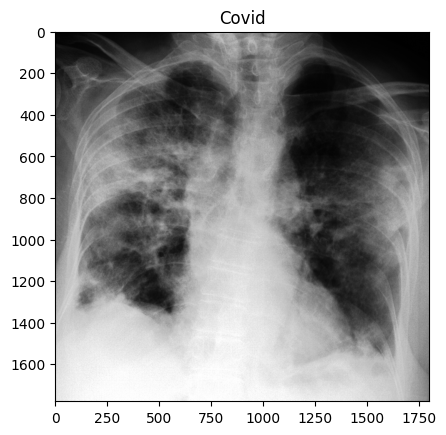

In [12]:
index = 100
plt.title(class_list[dset[index]['target']])
plt.imshow(dset[index]['image']) # 해당 번호의 이미지

# 4. 배열에 연산 가능한 텐서로 변환하기

In [13]:
# transforms.ToTenser(): 텐서로 변환하고 , 픽셀값으 ㅣ범위를 0 ~ 1 로 조정
# Resize(): 사이즈를 설정 224* 224
# Normalize() : 정규화, 
# 각 채널의 평균을 0.5 표준편차를 0.5로 정규화 하여 사용
transformer = transforms.Compose([ # 리스트로 등록을 할것이다.
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)), # 이미지 사이즈를 정사각형으로 크기를 동일화 시키는것이다.
    transforms.Normalize(mean=[0.5, 0.5, 0.5],# 정규화를 통해 값을 범위안에 들어가게 0과 1사이에 맞게 
                        std=[0.5, 0.5, 0.5]) )# 왜냐하면 서로 값이 다르는 경우가 있기 떄문에 척도를 동일하게 해준다.
    
])# 여러가지 작업을 한꺼번에 하게 하는것을 Compose를 이용

In [14]:
train_dset = Chest_dataset(train_data_dir, transformer)

In [15]:
index = 100
image = train_dset[index]['image']
label = train_dset[index]['target']

c:\users\administrator\appdata\local\programs\python\python38\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [16]:
print(image.shape, label) print(image.shape, label) # tensor[1] : 코로나
# 결과 : 3채널에 모양(크기)는 224*224, 코로나

torch.Size([3, 224, 224]) tensor([1])


# 5. 데이터 로더 구현하기

In [17]:
def build_dataloader(train_data_dir, val_data_dir):
    dataloaders = {}
    train_dset = Chest_dataset(train_data_dir, transformer)
    # {'train': 데이터...}
    dataloaders['train'] = DataLoader(train_dset, batch_size=4, shuffle=True, drop_last=True)
     # 트레인 데이터를 4개 씩 섞고 ,drop_last=True 마지막거를 버려라 
    # {'train' : 데이터...} 담긴 모습
    # 각각의 데이터의 특징(웨이트)을 분류하기 위해 4개로 분류하였고 한번에 전부를 돌리는것보단 조금씩 분석을 하면
    # 얼마만큼 틀렸거나 최적의 경로를 더 빨리 알 수 있기 때문에 적은 수인 4개 정도로 데이터를 분류하는것이 좋다.
    # 251개를 한번에 돌리면 시간이 오래걸리고 반복시에도 시간 문제가 발생한다.
    
    val_dset = Chest_dataset(val_data_dir, transformer)
    dataloaders['val'] = DataLoader(val_dset, batch_size=1, shuffle=False, drop_last=False)
    
    return dataloaders

In [18]:
train_data_dir = './Covid19-dataset/train/' # 학습 데이타
val_data_dir = './Covid19-dataset/test/' # 테스트 데이타
dataloaders = build_dataloader(train_data_dir, val_data_dir)

In [19]:
for i, d in enumerate(dataloaders['train']): # 반복 인덱스 값과 데이터 값을 출력을 해보자
    print(i, d)
    if i == 0:
        break
        
        # 출력 결과 한번 반복을 돌경우 4개로 나눴기 때문데 4개의 이미지가 있다.
        # target을 최하단부에 보면 섞인 타겟이 4개인것을 알 수 있다.

0 {'image': tensor([[[[-0.8308, -0.8916, -0.8677,  ..., -0.6797, -0.6646, -0.6471],
          [-0.8873, -0.8942, -0.9002,  ..., -0.6770, -0.6627, -0.6460],
          [-0.8754, -0.9074, -0.9250,  ..., -0.6893, -0.6627, -0.6432],
          ...,
          [-0.8985, -0.8763, -0.8768,  ..., -0.8388, -0.7755, -0.7307],
          [-0.8009, -0.8575, -0.8137,  ..., -0.8462, -0.9196, -0.7088],
          [-0.7368, -0.7897, -0.8608,  ..., -0.8182, -0.8737, -0.7346]],

         [[-0.8308, -0.8916, -0.8677,  ..., -0.6797, -0.6646, -0.6471],
          [-0.8873, -0.8942, -0.9002,  ..., -0.6770, -0.6627, -0.6460],
          [-0.8754, -0.9074, -0.9250,  ..., -0.6893, -0.6627, -0.6432],
          ...,
          [-0.8985, -0.8763, -0.8768,  ..., -0.8388, -0.7755, -0.7307],
          [-0.8009, -0.8575, -0.8137,  ..., -0.8462, -0.9196, -0.7088],
          [-0.7368, -0.7897, -0.8608,  ..., -0.8182, -0.8737, -0.7346]],

         [[-0.8308, -0.8916, -0.8677,  ..., -0.6797, -0.6646, -0.6471],
          [-0.8873

In [20]:
d['target'].shape

torch.Size([4, 1])

In [21]:
# 이제 어떤 모델을 선택해서 데이타를 넣어볼 것인가?!
# 모델을 직접 만들기도 하지만 기존 공개된 모델을 활용을 많이 한다.
# 여러 모델을 여러번 돌려보고 성능이 괜찮은걸 사용한다...


# 6. VGG19(classification) 모델 불러오기



In [22]:
# pretrained=True: 미리 학습된 weight들을 가지고 옮
# torchvision 의 models 사용...
model = models.vgg19(pretrained=True)

c:\users\administrator\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\users\administrator\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
# pytorch 모델을 summary 해주는 모듈
!pip install torchsummary

In [24]:
from torchsummary import summary
# 세이프, 배치사이즈, 디바이스
# param 가중치

In [25]:
summary(model, (3, 224, 224), batch_size=1, device='cuda') # 채널, 세로, 가로, device: cuda or cpu

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 224, 224]           1,792
              ReLU-2          [1, 64, 224, 224]               0
            Conv2d-3          [1, 64, 224, 224]          36,928
              ReLU-4          [1, 64, 224, 224]               0
         MaxPool2d-5          [1, 64, 112, 112]               0
            Conv2d-6         [1, 128, 112, 112]          73,856
              ReLU-7         [1, 128, 112, 112]               0
            Conv2d-8         [1, 128, 112, 112]         147,584
              ReLU-9         [1, 128, 112, 112]               0
        MaxPool2d-10           [1, 128, 56, 56]               0
           Conv2d-11           [1, 256, 56, 56]         295,168
             ReLU-12           [1, 256, 56, 56]               0
           Conv2d-13           [1, 256, 56, 56]         590,080
             ReLU-14           [1, 256,

# 7. CNN(Convolutional Neural Network)

- 합성곱 인공 신경망
- 전통적인 뉴럴 네트워크 컨볼루셔널 계층을 붙인 형태
- 컨볼루셔널 계층을 통해서 입력 받은 이미지에 대한 특징(Feature)을 추출(전처리)하게 되고
추출한 특징을 기반으로 기존의 뉴럴 네트워크에 이용하여 분류

### 7-1. CNN을 사용하는 이유

- 영상을 분류할 때 DNN(Deep Neural Network)의 문제점
    - 일반적인 DNN은 1차원 형태의 데이터를 사용
    - 2차원의 형태의 이미지가 입력되는 경우, flatten 시켜서 한줄로 데이터를 넣음
    - 이미지의 공간적/지역적 정보가 손실됨
- DNN의 문제점을 해결하기 위해 고안한 해결책 -> 이미지를 날것(raw input) 그대로 받음으로 공간적/지역적 정보를 유지


### 7-2. 컨볼루셔널 레이어(Convolutional Layer)

- 입력 데이터로 부터 특징을 추출하는 역할
- 특징을 추출하는 필터(Filter)를 사용함(https://setosa.io/ev/image-kernels/)
- 필터의 값을 비선형 값으로 바꿔주는 액티베이션(Activationi) 함수를 사용


### 7-3. 풀링

- Feature map의 사이즈를 줄이는 방법
- 데이터의 크기를 줄이고 싶을 때 선택적으로 사용
- max pooling: 사이즈를 점진적으로 줄이는 방법, 선명한 정보만 남겨서 판단과 학습이 쉬워지고 노이즈가 줄어듦

### 7-4. 패딩(padding)
- CNN 네트워크 특징중 여러 단계에 걸쳐서 계속 필터를 연속적으로 적용하면 필터 적용 후 결과값이 처음에 비해 작아지게 됨 -> 특징이 유실 될 수 있음
- 충분히 특징이 추출되기 전에 결과 값이 작아지지 않도록 패딩 기법을 사용
- 입력값 주위로 0을 넣어서 입력 값의 크기를 인위적으로 키워 결과값이 작아지는 것을 방지

### 7-5. 스트라이드(Stride)

- 필터를 적용하는 간격(예: 우측으로 한칸씩 아래로 한칸씩 적용)을 설정
- 필터를 적용해서 얻어낸 결과를 Feature map 또는 activation map이라고 부름


### 7-6. 드룹아웃 레이어(Dropout Layer)

- 오버피팅을 막기 위한 방법
- 뉴럴 네트워크가 학습중일때 랜덤하게 값을 발생하여 학습을 방해함으로 학습용 데이터에 결과가 치우치는 것을 방지함


### 7-7. FC Layer(Fully Connected Layer)

- 이미지를 분류/설명하기 위해 예측하는 구간


# 8. 데이터에 맞게 모델 Head 부분을 수정하기



In [26]:
def build_vgg19_based_model(device_name='cpu'):
    device = torch.device(device_name)
    model = models.vgg19(pretrained=True)
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, len(class_list)),
        nn.Softmax(dim=1)
    )
    return model.to(device)

In [27]:
model = build_vgg19_based_model(device_name='cpu')

In [28]:
summary(model, (3, 224, 224), batch_size=1, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 224, 224]           1,792
              ReLU-2          [1, 64, 224, 224]               0
            Conv2d-3          [1, 64, 224, 224]          36,928
              ReLU-4          [1, 64, 224, 224]               0
         MaxPool2d-5          [1, 64, 112, 112]               0
            Conv2d-6         [1, 128, 112, 112]          73,856
              ReLU-7         [1, 128, 112, 112]               0
            Conv2d-8         [1, 128, 112, 112]         147,584
              ReLU-9         [1, 128, 112, 112]               0
        MaxPool2d-10           [1, 128, 56, 56]               0
           Conv2d-11           [1, 256, 56, 56]         295,168
             ReLU-12           [1, 256, 56, 56]               0
           Conv2d-13           [1, 256, 56, 56]         590,080
             ReLU-14           [1, 256,

# 9. 손실함수 불러오기

- input x에 대한 예측값과 실제값 사이의 오차를 계산하는 함수
- cost function: 모든 input dataset에 대하여 계산하는 함수


In [29]:
loss_func = nn.CrossEntropyLoss(reduction='mean')

# 10. Gradient 최적화 함수 불러오기



In [30]:
optimizer = torch.optim.SGD(model.parameters(), lr=1E-3, momentum=0.9)

### 10-1. 경사 하강법의 종류

- 배치 경사 하강법
    - 가장 기본적인 경사 하강법으로 Vanilla Gradient Descent 라고 부름
    - 데이터셋 전체를 고려하여 손실함수를 계산
    - 한 번의 Epoch에 모든 파라미터 업데이터를 단 한번만 수행
    - Batch의 개수와 lteration은 1이고 Batch size는 전체 데이터의 갯수
    - 파라미터 업데이트할 때 전체 데이터셋을 고려하기 때문에 모델 학습시 많은 시간과 메모리가 필요하다는 단점
    
- 확률적 경사 하강법(Stochastic Gradient Descent)
    - 배치 경사 하강법이 모델 학습시 많은 시간과 메모리가 필요하다는 단점을 개선하기 위해 제안된 기법
    - Batch size를 1로 설정하여 파라미터를 덥데이트하기 때문에 배치 경사 하강법보다 빠르고 적은 메모리로 학습이 진행
    - 중복 데이터를 뽑을 가능성이 있음
    - 파라미터 값의 업데이트 폭이 불안정
    
- 미니 배치 경사 하강법
    - Batch size가 1도 아니고 전체 데이터 갯수도 아닌 경우
    - 배치 경사 하강법보다 모델 학습 속도가 빠르고, 확률적 경사 하강법보다 안정적인 장점이 있음
    - 일반적으로 Batch size를 2의 n제곱에 해당하는 값으로 설정
    

### 10-2. 경사 하강법의 알고리즘

- GD(Gradient Descent)
    - 모든 데이터를 사용하여 계산하는 방법으로 학습시간이 오래 걸림
- SGD(Stochastic Gradient Descent)
    - 확률적 경사 하강법으로 모든 데이터에 대해 가중치를 조절하는 것이 아닌 랜덤으로 일부를 추출해서 가중치를 조절하는 방법
- Momentum
    - 관성을 사용하는 방법으로 local minima를 해결하기 위해 고안
    - 이전의 방향을 기억하여 관성처럼 추가적인 이동을 하며 local minima 문제를 해결할 확률을 높임
- Adagrad
    - 학습률과 관련된 옵티마이저로, Adagrad라는 방식은 변수의 업데이트가 잦을수록 학습률을 조정하는 방식
- RMSprop
    - Adagrad은 학습률이 작아지는 문제가 발생
    - 위 문제를 해결하기 위해 만들어진 옵티마이저로, 기울기를 단순히 누적하는 것이 아닌 가중이동평균을 사용하여 최근의 기울기에 더 높은 가중치를 두는 방식을 적용한 방법
- Adam(Adaptive Moment Estimation)
    - Momentum을 사용
    - RMSprop처럼 지수이동평균을 사용하며 학습률을 조정
    
SGD와 Adam 두개를 최근 많이 사용한다...

# 11. 모델 검증을 위한 Accuracy 생성하기

In [31]:

@torch.no_grad() # 아래 붙어 있는함수가 작동을 할때
def get_accuracy(image, target, model):
    batch_size = image.shape[0]
    prediction = model(image)
    _, pred_label = torch.max(prediction, dim=1)
    is_correct = (pred_label == target)
    return is_correct.cpu().numpy().sum() / batch_size

# 12. 모델 학습을 위한 함수 구현하기

In [32]:
# 모델을 학습하기 위한 함수를 만들어보자
device = torch.device('cpu')

In [33]:
# epcoh: 데이터 전체를 한바퀴를 돌리는것?
# model: 우리가 학습한 모델
def train_one_epoch(dataloaders, model, optimizer, loss_func, device):
    losses = {} # 딕셔너리 타입으로 만들어준다...
    accuracies = {} 
    
    for tv in ['train', 'val']:
        running_loss = 0.0 # 얼마만큼 틀렸니를 누적...
        running_correct = 0 # 얼마만큼 맞았니를 누적...
        
        if tv == 'train':
            model.train() # 학습을 시킨다...
        else:
            model.eval() # 학습에 대한 메모리는 날리고 검증에 대한 메모리만 남긴다... no_grad()와 비슷...
            
        for index, batch in enumerate(dataloaders[tv]): # dataloaders 라는 객체에 train or val를 넣어준다...
            image = batch['image'].to(device)
            target = batch['target'].squeeze(dim=1).to(device) # squeeze: 차원축소, dim=1로 하면 1차원으롤 줄여주고, 값이 없으면 한차원 줄여줌
            
            
  # with : 파일 입출력에서 open을 사용하면 이 메소드들에 의해 사용되는 경우가 많은데, 마지막에 파일같은 경우에는
        # close를 해줘야 하는데 with를 하면 open하고 closs 할 필요가 없고 with내에 들여쓰기하여 사용을 하면 된다.
       # set_grad_enabled : 함수의미는 역전파 시키는 객체들을 메모리에 올려준다(학습에 필요한 데이터)
    # with문은 if문이 아니고 train일 때 이 함수를 사용하라는 거지 다른 경우도 들어올 수 있다.
            with torch.set_grad_enabled(tv == 'train'): # with: with문 밖으로 나가면 자원이 반납된다... val이어도 안으로 들어간다...
                prediction = model(image) # 모델에 이미지를 넣어서 예측값을 구한다...
                loss = loss_func(prediction, target)
                
                if tv == 'train':
                    optimizer.zero_grad() # zero_grad(): 기울기 초기화 시키라는...안해주면 틀린 loss값을 누적하게 된다.
                             # 옵티마이저 : SGD를 사용, zero_grad() : 초기화 시켜아
                                        # 이 옵티마이저는 실제 예측값을 구하고 차를 구해 
                        # 직선의 방정식에 의한 예측값을 뽑아 후에 
                        # 미분을 구해 어느 쪽으로 이동해야 하는지 학습률만큼 이동을 하고 기울기가 같은 것으로
                        # 초기화를 안하면 기울기 값을 구해야 하는데 계속 값이 추가되어   
                    loss.backward() # 역전파 계산, 미분
                    optimizer.step() # 새로운 기울기 적용
                    
            running_loss += loss.item()
            running_correct += get_accuracy(image, target, model)
            
            if tv == 'train':
                if index % 10 == 0:
                    print(f"{index}/{len(dataloaders['train'])} - Running loss: {loss.item()}")
                    
        losses[tv] = running_loss / len(dataloaders[tv])
        accuracies[tv] = running_correct / len(dataloaders[tv])
    return losses, accuracies
        

In [34]:
# 예측할때마다 학습을 시킨다면 오래걸리니 학습시킨 파일로 만들어준다
# 모델을 저장한 파일을 생기게 만든다. 학습하면서 저장위해 계속 학습보단 있는 내용을 파일로 저장해서 활용하자
def save_best_model(model_state, model_name, save_dir='./trained_model'):
    os.makedirs(save_dir, exist_ok=True) # 존재하면 덮어쓰겠다...
    torch.save(model_state, os.path.join(save_dir, model_name)) # 좋을때마다 저장해준다...
    
     # 계속 저장을 하면 너무 쓰잘데 없는 파일이 많이 생기기 때문에 로스 값이 적을 때만 저장을 할 조건을 정의하자

# 13. 모델 학습 수행하기


In [35]:
device = torch.device('cpu')

train_data_dir = './Covid19-dataset/train'
val_data_dir = './Covid19-dataset/test'

dataloaders = build_dataloader(train_data_dir, val_data_dir)
model = build_vgg19_based_model(device_name='cpu')
loss_func = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=1E-3, momentum=0.9)

In [ ]:
# num_epochs = 10 : 학습할 epoch 수를 설정합니다. 즉, 데이터셋 전체를 10번 반복하여 학습합니다.
# best_acc = 0.0 : 현재까지 최고 정확도를 저장하는 변수를 0.0으로 초기화합니다.
# train_loss, train_accuracy = [], [] : 학습 데이터셋의 손실과 정확도를 저장하기 위한 리스트를 생성합니다.
# val_loss, val_accuracy = [], [] : 검증 데이터셋의 손실과 정확도를 저장하기 위한 리스트를 생성합니다.
# 그리고 for loop을 통해 epoch 수만큼 반복하면서 다음 작업을 수행합니다.

# train_one_epoch 함수를 호출하여 학습을 수행합니다. 이 함수는 dataloaders에서 가져온 배치 데이터를 사용하여 모델을 학습하고, 학습 데이터셋과 검증 데이터셋의 손실과 정확도를 계산합니다.
# 각 epoch 마다 학습 데이터셋과 검증 데이터셋의 손실과 정확도를 각각의 리스트에 추가합니다.
# 학습 정보를 출력합니다.
# 만약 epoch 수가 3보다 크고 검증 데이터셋의 정확도가 현재까지의 최고 정확도보다 높은 경우, 모델의 상태를 best_model에 저장하고 최고 정확도를 best_acc에 저장합니다. 그리고 save_best_model 함수를 호출하여 최고 모델을 파일로 저장합니다.
# 최종적으로 최고 정확도를 출력합니다.
# 위 코드는 학습 과정에서 모델의 성능을 모니터링하고, 최고 성능을 달성한 모델의 상태를 저장하는 등의 다양한 기능을 포함하고 있습니다.

num_epochs = 10
best_acc = 0.0 # 가장 좋은 에크러시를 저장한다.
train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []

for epoch in range(num_epochs):
    losses, accuracies = train_one_epoch(dataloaders, model, optimizer, loss_func, device)
    train_loss.append(losses['train'])
    val_loss.append(losses['val'])
    train_accuracy.append(accuracies['train'])
    val_accuracy.append(accuracies['val'])
    
    print(f"{epoch+1}/{num_epochs} - Train Loss:{losses['train']}, val_Loss:{losses['val']}")
    print(f"{epoch+1}/{num_epochs} - Train Loss:{accuracies['train']}, val_Loss:{accuracies['val']}")
          
    if(epoch > 3) and (accuracies['val'] > best_acc):
        best_acc = accuracies['val']
        best_model = copy.deepcopy(model.state_dict())
        save_best_model(best_model, f'model_{epoch+1:02d}.pth')
        
print(f'Best Accracy: {best_acc}')

0/62 - Running loss: 0.5514792799949646
10/62 - Running loss: 0.5514469146728516
20/62 - Running loss: 0.5514477491378784
30/62 - Running loss: 0.5515957474708557
40/62 - Running loss: 0.5515661835670471
50/62 - Running loss: 0.5514467358589172
60/62 - Running loss: 0.5515074133872986
1/10 - Train Loss:0.555278088777296, val_Loss:0.5802884092836669
1/10 - Train Loss:0.9959677419354839, val_Loss:0.9848484848484849
0/62 - Running loss: 0.5524535775184631
10/62 - Running loss: 0.5515562891960144
20/62 - Running loss: 0.5514447689056396
30/62 - Running loss: 0.5514456629753113
40/62 - Running loss: 0.5514453649520874
50/62 - Running loss: 0.5515145063400269
60/62 - Running loss: 0.5514886379241943
2/10 - Train Loss:0.5552779349588579, val_Loss:0.5802884092836669
2/10 - Train Loss:0.9959677419354839, val_Loss:0.9848484848484849
0/62 - Running loss: 0.551478385925293
10/62 - Running loss: 0.5516049265861511
20/62 - Running loss: 0.5521795153617859
30/62 - Running loss: 0.5514485239982605
40/

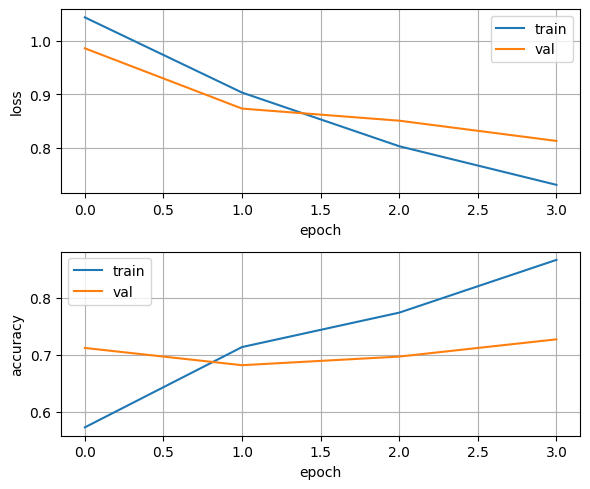

In [37]:
plt.figure(figsize=(6, 5))
plt.subplot(211)
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid('on')
plt.legend()
plt.subplot(212)
plt.plot(train_accuracy, label='train')
plt.plot(val_accuracy, label='val')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid('on')
plt.legend()
plt.tight_layout()

# 14. 테스트 이미지를 통한 학습모델 분류 성능 검증하기

In [38]:
data_dir = './Covid19-dataset/test/'
class_list = ['Normal', 'Covid', 'Viral Pneumonia']

test_normals_list = list_image_file(data_dir, 'Normal')
test_covids_list = list_image_file(data_dir, 'Covid')
test_pneumonias_list = list_image_file(data_dir, 'Viral Pneumonia')

In [39]:
def preprocess_image(image):
    transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                            std=[0.5, 0.5, 0.5]) # 값을 범위안에 들어가도록 재조정하는 것... 스탠다드스케일업

    ])
    
    tensor_image = transformer(image) # C, H, W
    tensor_image = tensor_image.unsqueeze(0) # 차원증가 B(batch), C, H, W
    return tensor_image

In [40]:
def model_predict(image, model):
    tensor_image = preprocess_image(image) # 전처리
    prediction = model(tensor_image) # 예측
    
    _, pred_label = torch.max(prediction.detach(), dim=1) # 라벨을 떼서 최고값을 구함
    print('prediction.detach: ', prediction.detach())
    print('pred_label: ', pred_label)
    pred_label = pred_label.squeeze(0)
    print('pred_label2: ', pred_label)
    return pred_label.item()
    
    

In [41]:
ckpt = torch.load('./trained_model/model_07.pth')

model = build_vgg19_based_model()
model.load_state_dict(ckpt) # 학습된 모델을 넣어줌
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [45]:
min_num_files = min(len(normals_list), len(covids_list), len(pneumonias_list))

@interact(index=(0, min_num_files-1))
def show_result(index=0):
    normal_image = get_RGB_image(data_dir, test_normals_list[index])
    covid_image = get_RGB_image(data_dir, test_covids_list[index])
    pneumonia_image = get_RGB_image(data_dir, test_pneumonias_list[index])
    
    prediction_1 = model_predict(normal_image, model)
    prediction_2 = model_predict(covid_image, model)
    prediction_3 = model_predict(pneumonia_image, model)
    
    
    plt.figure(figsize=(12, 8))
    
    plt.subplot(131)
    plt.title(f'Pred:{class_list[prediction_1]} | GT:Normal')
    plt.imshow(normal_image)
    
    plt.subplot(132)
    plt.title(f'Pred:{class_list[prediction_2]} | GT:Covid')
    plt.imshow(covid_image)
    
    plt.subplot(133)
    plt.title(f'Pred:{class_list[prediction_3]} | GT:Pneumonia')
    plt.imshow(pneumonia_image)
    plt.tight_layout()

interactive(children=(IntSlider(value=0, description='index', max=69), Output()), _dom_classes=('widget-intera…

# 15. 결론
* CNN에 대한 학습
* 이미지 데이터셋 구축
* Torchvision transforms 라이브러리를 활용한 텐서형 데이터 변환
* VGG 19 모델을 불러와 Head 부분을 수정
* Cross entropy Loss Function, SGDM 적용
* 인간 추론원리와 닮은 딥러닝 결과 출력